<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/2d_class_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Build intuition about 2D classification via expectation maximization in Fourier space

# Resources
* Nelson, P. C. (2019). Chapter 12 : Single Particle Reconstruction in Cryo-electron Microscopy. In Physical Models of Living Systems (pp. 305–325). https://repository.upenn.edu/cgi/viewcontent.cgi?article=1665&context=physics_papers
* Sigworth, F. J., Doerschuk, P. C., Carazo, J.-M., & Scheres, S. H. W. (2010). An Introduction to Maximum-Likelihood Methods in Cryo-EM. In Methods in Enzymology (1st ed., Vol. 482, pp. 263–294). Elsevier Inc. http://doi.org/10.1016/S0076-6879(10)82011-7
* Sigworth, F. J. (1998). A Maximum-Likelihood Approach to Single-Particle Image Refinement. Journal of Structural Biology, 122(3), 328–339. http://doi.org/10.1006/jsbi.1998.4014
  * Early reference of similar analysis as in this notebook. The paper has "Maximum-Likelihood" in the title, but uses an expectation maximization approach and cites EM literature.
  * simulated data
      * the particle was 3 fold symetric and C3 averaging was done
    * angles in 7.5 degree steps (16 steps covering 120 deg $\implies$ 360 deg for the C3 symetry)
    * translation was gaussian with std of 10 pixels in x and y
    * 4000 noisy images
    * each iteration took ~30 min of compute time on a Power Macintosh G3

* Do, C. B., & Batzoglou, S. (2008). What is the expectation maximization algorithm? Nature Biotechnology, 26(8), 897–899. http://doi.org/10.1038/nbt1406
* Asarnow, D., Palovcak, E., Cheng, Y. UCSF pyem v0.5. Zenodo https://doi.org/10.5281/zenodo.3576630 (2019)
  * Some of the code from this repository is used in this notebook
  * Asarnow et al's pyem code is under a gnu general public liscence
* Fan, G., Baker, M. R., Wang, Z., Seryshev, A. B., Ludtke, S. J., Baker, M. L., & Serysheva, I. I. (2018). Cryo-EM reveals ligand induced allostery underlying InsP3R channel gating. Cell Research, 28(12), 1158–1170. http://doi.org/10.1038/s41422-018-0108-5
  * The 3D map of the membrane protein used as an example is taken from this paper ([EMD-9243](https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-9243/index)).


# Set up

In [ ]:
%%bash
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py


--2020-06-17 18:17:26--  https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13245 (13K) [text/plain]
Saving to: ‘mrc.py’

     0K .......... ..                                         100% 53.0M=0s

2020-06-17 18:17:26 (53.0 MB/s) - ‘mrc.py’ saved [13245/13245]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mrc

In [ ]:
%%bash
pip install pyFFTW

In [ ]:
def do_2dplot(arr):
  plt.imshow(arr, cmap='gray')

def do_1dplot(arr,idx=None,**kwargs):
  sr = pd.Series(arr)
  if idx is not None: sr.index=idx
  sr.plot(**kwargs)

def log_abs(arr):
  return(np.log(1+np.abs(arr)))

# Image Formation (Forward Model)
* CryoEM images are images of thin aqueous biomolecules embedded in a thin state of "glassy" ice. 
* They are imaged by a transmission electron microscopes (TEMs) with pixel sizes of 0.5 - 2 A (10 A = 1 nm).
  * Images are usually around 4000 pixels wide, and have tens to hundreds of single particles (our biochemically purified molecule of interest). Images can be single frame (micrographs) or multiframe (movies).
  * The single particles are boxed out (ie picked) from the micrographs/movies and are typically 100-400 pixels wide, depending on the pixel size and protein size.
* The TEM is operated in a phase contrast mode, and the image need to be taken out of focus (defocused) in order to see detail. This corrupts the image, and is computationaly undone during data processing.
* The image is formed by how the electron interacts with the thin sample. Mathematically this is a line integral through the atomic potential. 
* Therefore we can simulate data with a forward model
  * Start with an scalar densit map
  * Take a line integral through one direction
  * Corrupt the image with the contrast transfer function
  * Add noise



In [ ]:
%%bash
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-9243/map/emd_9243.map.gz
gunzip emd_9243.map.gz


In [ ]:
fname = 'emd_9243.map'#'/content/drive/My Drive/repos/learn_cryoem_math/data/ouhn_Data1_P1/emd_9243_downsample_64pix.mrc'#emd_9243_downsample_128pix_lp3A.mrc.mrc'#'emd_9243.map'
vol = mrc.read(fname)
psize_A = 1.26 #3.9375
#nx = vol.shape[0]

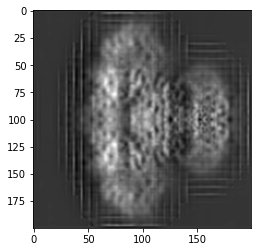

In [ ]:
image_2d = vol.mean(0)
nx = image_2d.shape[0]
plt.imshow(image_2d,cmap='gray')

This is our ground truth image (before noise and ctf). This is what we do not observe in an actual experiment and what we are trying to recover.

## Discrete Fourier Transform (DFT)
In short DFT decompose an image into a series of zebra-striped oscilating 2d images (sin and cos). In the new 'Fourier space', each pixel represents how much a striped image contributes to make up the original. 
  * The DFT is an approximation to the fourier transform. Doing the DFT and then doing its inverse perfectly recover the original function at the grid points, so at the grid points it is not an approximation but exact.
  * The Fast Fourier Transform (FFT) is algorithmic routine for computing the discrete fourier transform. There can be numerical errors associated with the FFT as implemented relative to the analytical DFT.
  * The origin is at the centre of the 2D image (there are different conventions in software implementations, but we will use this one here)
    * pixels closer to the origin have less oscilations per image (lower resolution information / larger spatial blobs)
   * pixels further to the origin have more oscilations per image (higher resolution information / smaller structural detail)
   * at the same radius from the origin, as we go around the pixels at different angles, the striped patterns rotate
   * the scale of the axes in fourier space are 1/distance in steps of 1/(span of image in real space)
    * e.g is the image is 100 pixels, and the pixel size is 1 A, then the bins are [1/(100 A) ,2/(100 A),3/(100 A), ..., 50 /(100 A)] starting at the origin and moving away. It may be helpful to think of the pixels as short hand for [0 to 1/(100 A) ,1/(100 A) to 2/(100 A),...] but at the same time the pixels are just discrete samples and we will not have oscilations corresponding to distance scales between the samples. 
    * The inverse scaling makes things non-linear in distance space, so the bins correspond to distances of [$\infty$-100 A, 100-50 A, 50-33.3 A, 33.3-25 A, ..., 2.04-2 A].
  * Fourier transform values are complex, and are sometimes represented by the cos and sin contributions in the literature (real and imaginary part)
* It is very convenient to work in Fourier space to apply masks (low pass, high pass, rectangle, Gaussian, Butterworth).

# Further reading
* Briggs, W. L., & Hensen, V. E. (1995). The DFT: an owner’s manual for the discrete Fourier transform (1st ed.). Society for Industrial and Applied Mathematics.
* Hobbie, R. K., & Roth, B. J. (2007). Intermediate Physics for Medicine and Biology (4th ed.). New York, NY: Springer New York. http://doi.org/10.1007/978-0-387-49885-0
  * Chpater 11 The Method of Least Squares and Signal Analysis
  * Chapter 12 Images
* Gonzalez, R. C., & Woods, R. E. (2017). Digital Image Processing (4th ed.).
  * Chapter 4: Filtering in the Frequency Domain

In [ ]:
import pyfftw, numpy
import numpy.fft
import pyfftw.interfaces.numpy_fft
from numba import jit

def fft2d(arr2d,mode,numpy_fft=pyfftw.interfaces.numpy_fft):
  '''
  we apply an alterating +1/-1 multiplicative before we go to/from Fourier space. 
  Later we apply this again to the transform.
  '''
  assert arr2d.ndim == 2
  n1,n2 = arr2d.shape
  assert n1==n2
  arr2d = neg_pos(arr2d.copy())
  if mode=='f':
    arr2d_f = numpy_fft.fftn(arr2d.reshape(-1,n1,n1),axes=(-2,-1))
    arr2d_f /= n1
  elif mode=='i':
    arr2d_f = numpy_fft.ifftn(arr2d.reshape(-1,n1,n1),axes=(-2,-1)).real
    arr2d_f *= n1
  
  arr2d_f = neg_pos(arr2d_f.reshape(n1,n1).copy())
  return(arr2d_f)

def do_fft(arr2d,**kwargs):
  return(fft2d(arr2d,mode='f',**kwargs))

def do_ifft(arr2d,**kwargs):
  return(fft2d(arr2d,mode='i',**kwargs))

@jit
def neg_pos(arr2d):
  '''
  each pixel switches from positive to negative in checker board pattern
  '''
  assert arr2d.ndim == 2
  for r in range(arr2d.shape[0]):
    for c in range(arr2d.shape[1]):
      if (r+c)%2:
        arr2d[r,c] *= -1
  return(arr2d)




In [ ]:
%timeit do_fft(image_2d,numpy_fft=pyfftw.interfaces.numpy_fft)
%timeit do_ifft(image_2d_f,numpy_fft=pyfftw.interfaces.numpy_fft) 
%timeit do_fft(image_2d,numpy_fft=numpy.fft)
%timeit do_ifft(image_2d_f,numpy_fft=numpy.fft) 


The slowest run took 5.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 782 µs per loop
The slowest run took 13.18 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 79.8 µs per loop
1000 loops, best of 3: 1.48 ms per loop
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 121 µs per loop


The FFT implementation in `pyfftw` is slightly faster than  `numpy.fft`, so we will go with `pyfftw`.

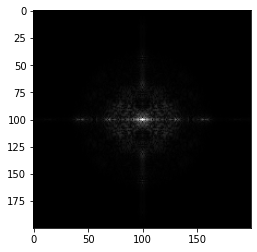

In [ ]:
image_2d_f = do_fft(image_2d)
plt.imshow(log_abs(image_2d_f),cmap='gray')

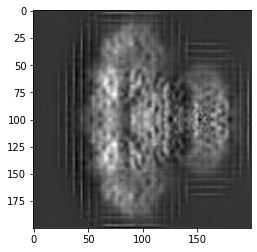

In [ ]:
plt.imshow(do_ifft(image_2d_f),cmap='gray')


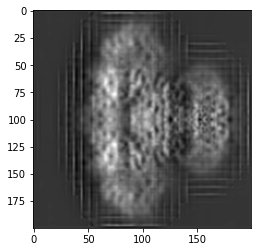

In [ ]:
plt.imshow(image_2d,cmap='gray')


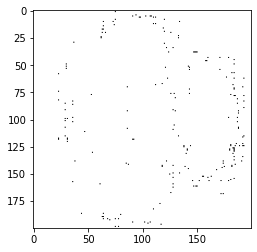

In [ ]:
plt.imshow(np.isclose(do_ifft(do_fft(image_2d)), image_2d,atol=1e-8),cmap='gray')


There is some error in the transforms to Fourier space and back, but it is minimal

## Contrast Transfer Function
* The image gets corrupted by the microscope. Mathematically it's a convolution. In Fourier space this convolution turns into a multiplication. The Fourier transform of the microscope's modulation transfer function is called the contrast transfer function (CTF). The CTF for the type of imaging in cryoEM is well characterized, and is derived from first principles in electron optics literature.
* The mathematical form is a rapidly oscilating sinusoid

In [ ]:
%%bash
cd /
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/ctf.py
sed 's/fftfreqs/fftfreq/' /ctf.py > /ctf_fix.py # this is for some numpy version fix

--2020-06-17 21:37:20--  https://raw.githubusercontent.com/asarnow/pyem/master/pyem/ctf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4643 (4.5K) [text/plain]
Saving to: ‘ctf.py.1’

     0K ....                                                  100% 41.9M=0s

2020-06-17 21:37:20 (41.9 MB/s) - ‘ctf.py.1’ saved [4643/4643]



/


(0, 1.4141048100282938e-05)

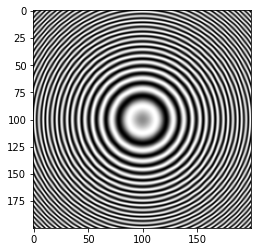

In [ ]:
%cd /
import ctf_fix as ctf

s, a = ctf.ctf_freqs(image_2d.shape,d=1/psize_A)
df = 10000
ctf_2d = np.fft.fftshift(ctf.eval_ctf(s, a, def1=df, def2=df, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0))
plt.imshow(ctf_2d,cmap='gray')
np.isclose(ctf_2d,0).sum(), np.abs(ctf_2d).min()

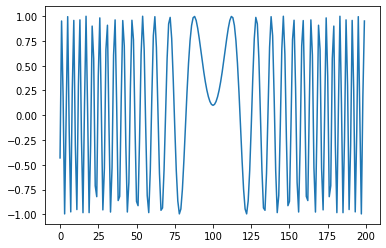

In [ ]:
pd.Series(ctf_2d[nx//2]).plot()

### Applying the CTF


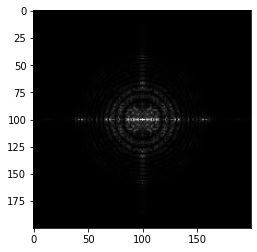

In [ ]:
image_2d_f_ctf = image_2d_f*ctf_2d
plt.imshow(np.abs(image_2d_f_ctf), cmap='gray')

It is hard to see any different in the Fourier image, because there's not much high frequency detail away from the origin. But the Thon ring pattern has been multipled through in the image.

Let's see what the new image looks like in real space.

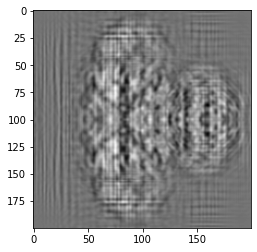

In [ ]:
plt.imshow(do_ifft(image_2d_f_ctf), cmap='gray')

Compare this to how an out of focus image looks like.

### Un-doing the CTF
The CTF oscilates. When the CTF multiples the Fourier image, we can undo this by dividing by it. However, what about the zeros? We won't know the value of the image that was at these zeros. 

Let's first try to divide, and then set the infinity / undefined values to some constant.

Note that in this case the CTF never actually reaches zero on the grid points. So we artificially bring the values that are close to zero to zero to illustrate the point. In practice, with larger pictures the grid points are finer and the CTF gets too close to zero and amplifies values too much.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


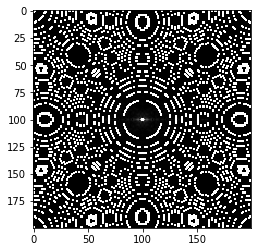

In [ ]:
ctf_2d_zeros = ctf_2d.copy()
ctf_2d_zeros[np.isclose(ctf_2d,0, atol=0.1)]=0

image_2d_f_ctf = image_2d_f*ctf_2d_zeros

image_2d_f_undoctf = image_2d_f_ctf / ctf_2d_zeros
plt.imshow(np.abs(image_2d_f_undoctf), cmap='gray')

The white dots are where the CTF was zero. Let's just set these to zero.

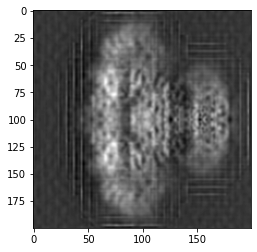

In [ ]:
image_2d_f_undoctf[np.isnan(image_2d_f_undoctf)] = 0
plt.imshow(do_ifft(image_2d_f_undoctf), cmap='gray')

We can see the error agains the original image

error 19.003462457512157


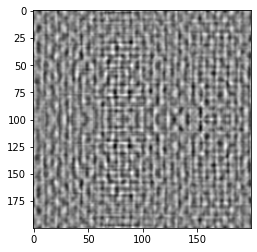

In [ ]:
plt.imshow(do_ifft(image_2d_f_undoctf) - image_2d,cmap='gray')
print('error',np.linalg.norm(do_ifft(image_2d_f_undoctf)-image_2d))


We could also try to interpolate the values... but does this make sense in Fourier space? Instead, let's try to do something more subtle. Instead of dividing by zero and getting infinity, we will add in some noise, so that the value at these zeros will be brought to the noise level. This is called the Wiener filter. [This link](http://www.bio.brandeis.edu/~shaikh/lab/ctf.htm) is a bit legacy, but instructive nonetheless


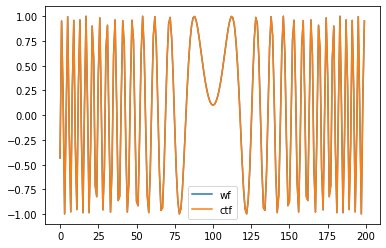

In [ ]:
snr_wf=5000

image_2d_f_ctf = image_2d_f*ctf_2d
wf = ctf_2d / (ctf_2d**2 + 1/snr_wf)
#plt.imshow(wf, cmap='gray')
pd.Series(1/wf[nx//2]).plot(legend=True, label='wf')
pd.Series(ctf_2d[nx//2]).plot(legend=True, label='ctf')

The Wiener filter dampens the CTF

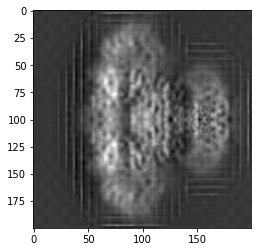

In [ ]:
image_2d_f_undoctf = image_2d_f_ctf * wf
plt.imshow(do_ifft(image_2d_f_undoctf), cmap='gray')

error 2.501222047701707


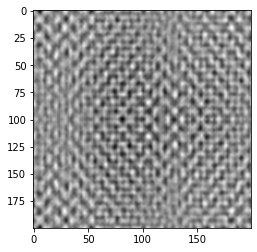

In [ ]:
plt.imshow(do_ifft(image_2d_f_undoctf) - image_2d,cmap='gray')
print('error',np.linalg.norm(do_ifft(image_2d_f_undoctf)-image_2d))


The error is better, but at the price of an extra parameter. In practice how would we estimate a suitable `snr` value for the Wiener filter? Perhaps this parameter can also be learned from the data?

## Noise

White noise in this context means that the noise in each pixel is iid with the other pixels.

It turns out that the Fourier transform of gaussian white noise is also gaussian, and the new variance is proportional to the old variance. We can therefore add the noise in Fourier space. See [this link](https://dsp.stackexchange.com/questions/24170/what-are-the-statistics-of-the-discrete-fourier-transform-of-white-gaussian-nois) for a proof.


Let's quickly add the noise in real space and Fourier space and convince ourselves that it's the same thing, up to some constant.

real space white noise 0.2221013837665578


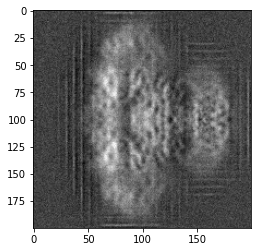

In [ ]:
snr = 3
noise_std = image_2d.std() / snr
noise = np.random.normal(0,noise_std,nx*nx).reshape(nx,nx)
image_2d_noise = image_2d + noise
do_2dplot(image_2d_noise)
print('real space white noise',image_2d_noise.std())

fourier white noise 0.21777787824618386


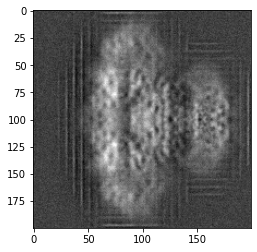

In [ ]:
snr = 3
noise_std = image_2d_f.std() / snr
noise = np.random.normal(0,noise_std,nx*nx).reshape(nx,nx)
image_2d_f_noise_r = do_ifft(image_2d_f + noise)
do_2dplot(image_2d_f_noise_r)
print('fourier white noise',image_2d_f_noise_r.std())

## Rotation

It turns out that a rotation in real space is the same as a rotation in Fourier space. There's a nice explicit proof of it [here](https://www.eee.hku.hk/~work8501/WWW2008/ho4.pdf) for the 2D case. This actually holds in any dimension, because the rotation matrix commutes with the Fourier transform.

This means that we can search for the rotation in Fourier space, and the angle identified will be the same angle in real space that the image is rotated.

Note that the CTF is not rotationally invariant when the defocus angles are different, so we have to keep track of what order we are doing the rotation and ctf correction. In measured data the ctf parameters are first estimated from the image, which is rotated in all sorts of ways. So for the forward model we would want to rotate, and then apply the CTF.

Rotate the image in real space and compare the Fourier transforms


In [ ]:
#from scipy.ndimage import rotate
from scipy.ndimage.interpolation import rotate

def do_complex_rotate(arr,angle,rotate_func=rotate, **kwargs):
  r = rotate(np.real(arr),angle=angle, reshape=False, **kwargs)
  i = rotate(np.imag(arr),angle=angle, reshape=False, **kwargs)
  return(r+i*1j)

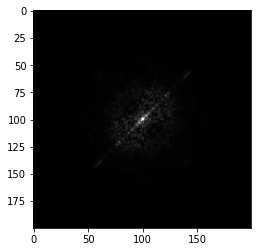

In [ ]:
image_2d_f = do_fft(image_2d)
image_2d_f_rot = do_complex_rotate(image_2d_f,angle=45, prefilter=False)
do_2dplot(log_abs(image_2d_f_rot))

### Mask / window
* Note the edges. The rotation, as implemented here, does not estimate what is outside the image. We don't want to take the inverse FT of this, since it will have artefacts. If we apply a circular filter before doing the ifft, then the edges will go away, and all rotations will look like a circle. We loose high frequency detail at the edges, but this doesn't make much difference for 2D classification.
* We will use a "step function like" circular mask, but we could also use other masks that are gradual (Gaussian, Butterworth)

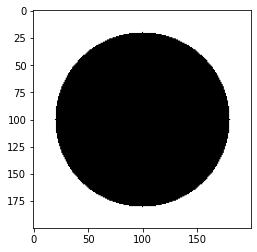

In [ ]:
def cmask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius
  return(mask)

bool_circle_mask = ~cmask(index=(nx//2,nx//2),radius=int(nx//2*0.8),array=np.ones_like(image_2d)).astype(np.bool)
plt.imshow(bool_circle_mask, cmap='gray')

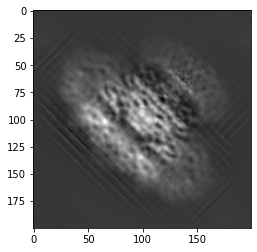

In [ ]:
image_2d_f = do_fft(image_2d)
image_2d_f_rot = do_complex_rotate(image_2d_f,angle=45, prefilter=False)
image_2d_f_rot[bool_circle_mask]=0
do_2dplot(np.abs(image_2d_f_rot))
plt.imshow(do_ifft(image_2d_f_rot), cmap='gray')

In [ ]:
image_2d_f_rot.shape

(200, 200)

The image rotated by the same angle, as expected. Now let's see if the rotated image correlates in Fourier space. We can 
  * rotate, then  FT
  * FT, then rotate

In theory, these should agree, but it is worthwhile to check because the rotation implementation interpolates. In Fourier space this can be more dramatic since the nearby pixels are less correlated. In practice this has been a tricky point that I have not fully resolved. (fft -> rotate -> iff makes an image with large stripe/streak/band artefacts. Without rotation there are no artefacts).

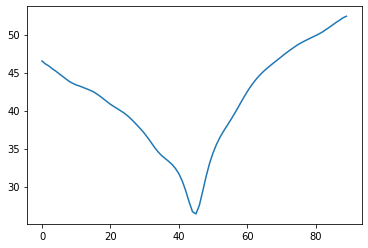

In [ ]:
image_2d_rot = rotate(image_2d, angle=45, reshape=False)
image_2d_rot[bool_circle_mask]=0
image_2d_rot_f = do_fft(image_2d_rot)

error_list = []
angles=range(0,90,1)
for angle in angles:
  error_list.append(np.linalg.norm((image_2d_rot_f - do_complex_rotate(image_2d_f,angle))[~bool_circle_mask]))
errors = pd.Series(error_list)
errors.index = [angle for angle in angles]
errors.plot()

We can see that the error is minimized around the exected angle. This verifies we can search for the rotation in Fourier space.

## Simulate data (many particles)
Now we can put the pieces together and simulate many particles at different rotations, with different CTFs. In practice, people take images at a range of CTFs so that the lost information is recovered from some of the particles.

In practice a microscope may sit at a given defocus during image aquisition, but the actual CTF does change because the physical height of the sample changes because it is not perfectly flat.

Here we will use a generous range of defocus, uniform, from 1 um to 2 um, with zero astigmatism for simplicity.

CPU times: user 8.72 s, sys: 264 ms, total: 8.99 s
Wall time: 8.99 s


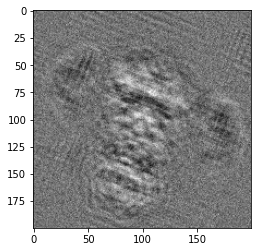

In [ ]:
%%time
N_particles = 500
image_2d_f = do_fft(image_2d) # ground truth image

true_angles = np.random.uniform(low=0,high=360, size=N_particles)

ctf_2ds = np.zeros((N_particles,nx,nx))
dfs = np.random.uniform(low=1e4,high=2e4,size=N_particles)

snr = 3
noise_std = image_2d_f.std() / snr

images_observed = np.zeros((N_particles,nx,nx), dtype=np.complex64)

for i in range(N_particles):
  # rotate
  image_2d_f_rot = do_complex_rotate(image_2d_f,angle=true_angles[i])
  image_2d_f_rot[bool_circle_mask]=0
  # ctf
  ctf_2ds[i,:,:] = np.fft.fftshift(ctf.eval_ctf(s, a, def1=dfs[i], def2=dfs[i], angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0))
  image_2d_f_rot_ctf = image_2d_f_rot*ctf_2ds[i]
  # noise
  noise = np.random.normal(loc=0,scale=noise_std,size=nx*nx).reshape(nx,nx)
  images_observed[i,:,:] = image_2d_f_rot_ctf + noise

do_2dplot(do_ifft(images_observed[0]))


# 2D Classification: Expectation-Maximization
This is a direct extension of the exquisitly pedagogical textbook chapter by Philip Nelson.
* Nelson, P. C. (2019). Chapter 12 : Single Particle Reconstruction in Cryo-electron Microscopy. In Physical Models of Living Systems (pp. 305–325). https://repository.upenn.edu/cgi/viewcontent.cgi?article=1665&context=physics_papers

New additions include
* Incorporating the CTF
* Doing the expectation and maximization steps in Fourier space

Future work includes
* Learning parameters from the data
* Searching for shifts in Fourier space (The shifts in Fourier space factorize with a multiplication, so it parallelizes / factorizes nicely)

### Reference aligned templates
We start off with some template. This can be some previous estimate of the 2D class, or some guess that assumes very little (average of the particles, 2D gaussian blob). The problem of template bias (Einstein from Noise) is well reported in the literature, and so we will eventually choose to average the data as our starting point).

However, to see what is happening at each step of the algorithm, and peek into the data. We start off with the ground truth.



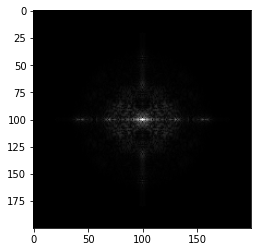

In [ ]:
A_prev = do_fft(image_2d)
A_prev[bool_circle_mask] = 0
do_2dplot(log_abs(A_prev))

We first make a reference library of templates.

In [ ]:
deg_step=1
angles = np.arange(0,360,deg_step)
A_rot = np.zeros((nx,nx,angles.shape[0]), dtype=np.complex64)

for angle_idx, angle in enumerate(angles):
  A_rot[:,:,angle_idx] = do_complex_rotate(A_prev,angle=angle)

### Table of norms of reference aligned templates

This term comes from the mean squared error between the observed image and template. 

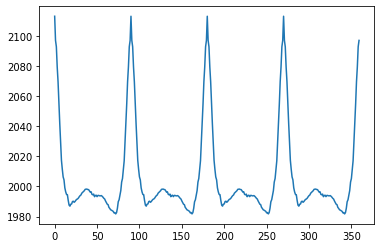

In [ ]:
A_aligned_norm = np.linalg.norm(A_rot[:,:,:],axis=(0,1))**2
A_aligned_norm.shape
do_1dplot(A_aligned_norm)

The peaks are due to the interpolation of the rotation function. This also happens in real space. Here the error is just a few percent.

In [ ]:
(A_aligned_norm.max() - A_aligned_norm.min())/(0.5*(A_aligned_norm.max() + A_aligned_norm.min())) *100

6.429647695061655

We will be looping over the images. By expanding the term, we can factor our what terms depend on our observed images, and what only depend on the template. So we only need to recompute this term when the template is updated.

In [ ]:
sigma = noise_std
A_aligned_norm_  = -(2*sigma**2)**-1*A_aligned_norm

## Correlation of aligned templates and the (CTF corrected) observed iamge
In real space, the correlation has no imaginary part. But the definition of the correlation extends naturally to include the imaginary part. There are likely faster  implementations to compute this, but below is a function for pedagogical purposes.

### Undo CTF

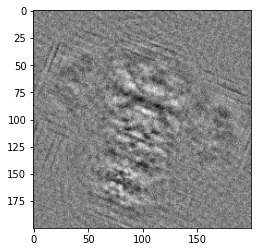

In [ ]:
i=0
snr_wf = 5000
wf = ctf_2ds[i] / (ctf_2ds[i]**2 + 1/snr_wf)
x =  images_observed[i].copy()
x /= wf

### Mask / window

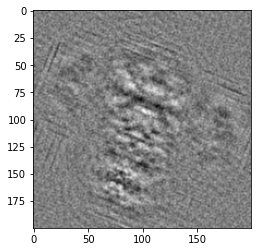

In [ ]:
x[bool_circle_mask] = 0
do_2dplot(do_ifft(x))

### Correlate
The values outside the window are zero, and will contribute zero to the correlation. Hence we can just compute those inside the window.

The cross correlation implemented below is the same as other correlations, but only the real part. It's like a pixel wise [Fourier Shell Correlation](https://en.wikipedia.org/wiki/Fourier_shell_correlation), but just the numerator. We could use an implementation of a cross correlation, and take the real part [same as averaging xcor(a,b) with xcor(b,a)].

In [ ]:
def comp_corr(a,b):
  '''
  cross correlation in Fourier space
  the cross correlation of the real and imaginary parts and adds them up
  '''
  corr = np.multiply(np.real(a), np.real(b)).sum() + np.multiply(np.imag(a), np.imag(b)).sum()
  return(corr)
  
x = images_observed[0]
comp_corr(x[~bool_circle_mask],A_rot[:,:,0][~bool_circle_mask])

66.42334

In [ ]:
corr_A_x = np.zeros_like(A_rot[0,0], dtype=np.float32)
for angle_idx in range(angles.shape[0]):
  corr_A_x[angle_idx] = comp_corr(x[~bool_circle_mask],A_rot[:,:,angle_idx][~bool_circle_mask])

248.1684531687967


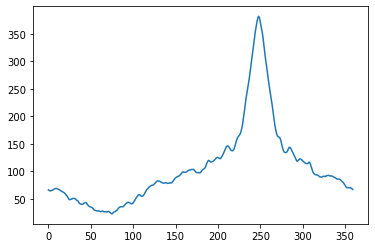

In [ ]:
do_1dplot(corr_A_x, idx=angles)
print(true_angles[i])

Here we see the correlation, which is the basis of the probability distibution over the angles. So far the white nosie parameter `sigma` has not affected how this is computed. We will see below that `sigma` scales things in a non-linear way, making the peaks more peaky.

### $\gamma_i$, $K_i$

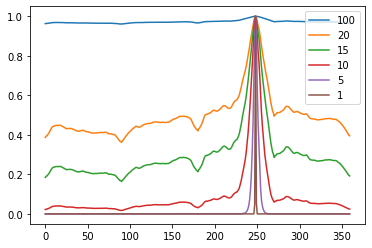

In [ ]:
for sigma in [100,20,15,10,5,1]:
  corr_A_x_ = sigma**-2*corr_A_x
  A_aligned_norm_  = -(2*sigma**2)**-1*A_aligned_norm
  loggi = A_aligned_norm_ + corr_A_x_ 
  Ki = loggi.max()
  gi = np.exp(loggi-Ki)
  do_1dplot(gi/gi.max(), legend=True, label=sigma)



This makes sense. When there is more noise, there is more uncertainty about how accurate our correlations are for each angle, and the distribution over angles flattens out.

### Accumulate log likelihood
* compute $U, L$

In [ ]:
Ui = gi.sum()**-1; Ui

0.9074777322749601

In [ ]:
L = -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x[~bool_circle_mask])**2; L

-1376.1803107095507

Each image will contribute a term to the log likelihood, because `Ui`, `Ki` and `x` depend on the image.

## Reverse the alignment
We rotated the template `A_prev` by `+angle` to generate `A_rot`. We have to rotate the observed image by `-angle` to match the observed image to `A_prev`. 

In [ ]:
x_aligned = np.zeros_like(A_rot)
x[bool_circle_mask] = 0
for angle_idx in range(angles.shape[0]):
      x_aligned[:,:,angle_idx] = do_complex_rotate(x,-angles[angle_idx]) 

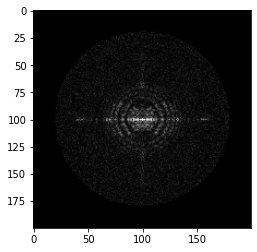

In [ ]:
best_angle_idx = np.argmax(corr_A_x)
do_2dplot(log_abs(x_aligned[:,:,best_angle_idx]))

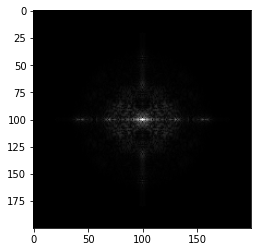

In [ ]:
do_2dplot(log_abs(A_prev))

This verifies the alignment visually in Fourier space 

## Maximization
At this point we could choose to use the best angle as a point estimate, and update the template with the corresponding image from the best angle. However, for noisy cryo data, and early stage templates, there is lots of variance in our alignment distibutions. A point estimate neglects this variance, and can reinforce bias in the templates. Instead of throwing out all the information we have, and waste all the computations we have done, we can do a Bayesian update.

The new updated template is computed pixel by pixel. The one (CTF corrected) observed image has been expanded into a rotated library, and each of those references has an associated probability of how likely the rotation is. So form a pixel in the new image from the same location pixel in all the reference images, weighted by their probability.

As the probability distrubution over angles becomes more and more of a peak, the baysian update becomes more and more like a point estimate.

We can implement the update as a loop, or multiply through by the probabilities and then compute the vectorized average.

Why can we do the Bayesian updating in Fourier space? Because the FT is a linear operator: the average of ffts of the image is the same as the fft of averaged images. Thus we can average the pixels of the fourier images, and then transform back to real space at the end for visualization purposes.

### Loop update

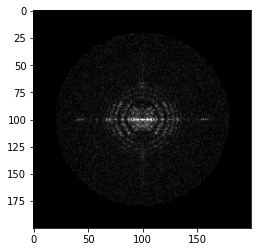

In [ ]:
A_next = np.zeros_like(A_prev)
conv = np.zeros_like(A_prev)
for nr in range(A_prev.shape[0]):
  for nc in range(A_prev.shape[1]):
    if not bool_circle_mask[nr,nc]:
      # sum over alignments
      conv[nr,nc] = np.multiply(gi,x_aligned[nr,nc]).sum() # each aligned picture contributes a weighted (by how good its alignment was) amount to the updated template
      A_next[nr,nc] += Ui*conv[nr,nc] # perhaps accumulate and sum later... maybe better numerical stability
do_2dplot(log_abs(A_next))

### Vectorized update

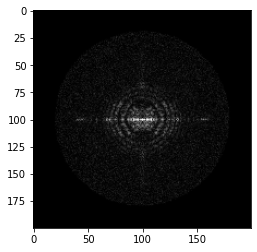

In [ ]:
A_next = np.zeros_like(A_prev)
A_next += Ui*np.multiply(gi.reshape(1,1,-1),x_aligned).sum(axis=-1)
do_2dplot(log_abs(A_next))

# Full 2D Class e-m algorithm (with CTF in Fourier space)
We initilize the template by averaging over the randomly aligned images. This makes a bulls eye type image, with the high resolution noise averaging out.

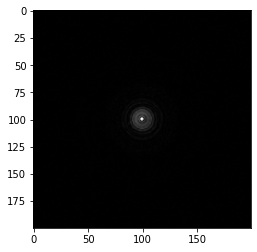

In [ ]:
A = do_fft(image_2d)
X = images_observed
A_prev = X.mean(0)
A_next = A_prev.copy()
do_2dplot(log_abs(A_prev))

In [ ]:
deg_step = 1
angles = np.arange(0,360,deg_step)
sigma = noise_std
snr_wf = 5000

i = 0, ll = -1986991.18, A_next max = 20.25
i = 50, ll = -105265317.43, A_next max = 923.07
i = 100, ll = -207320323.05, A_next max = 1823.66
i = 150, ll = -310292501.30, A_next max = 2727.34
i = 200, ll = -413098863.58, A_next max = 3637.33
i = 250, ll = -516380563.80, A_next max = 4535.41
i = 300, ll = -618287948.14, A_next max = 5439.52
i = 350, ll = -721928826.42, A_next max = 6337.32
i = 400, ll = -826051151.48, A_next max = 7235.54
i = 450, ll = -928903127.64, A_next max = 8132.64
i = 0, ll = -1852680.46, A_next max = 36.78
i = 50, ll = -98228298.09, A_next max = 944.71
i = 100, ll = -193408331.56, A_next max = 1849.89
i = 150, ll = -289442326.69, A_next max = 2758.65
i = 200, ll = -385357744.74, A_next max = 3669.96
i = 250, ll = -481827825.01, A_next max = 4569.32
i = 300, ll = -576840940.53, A_next max = 5474.84
i = 350, ll = -673578437.30, A_next max = 6375.65
i = 400, ll = -770841843.74, A_next max = 7277.14
i = 450, ll = -866877708.27, A_next max = 8176.87
i = 0, ll = -1842

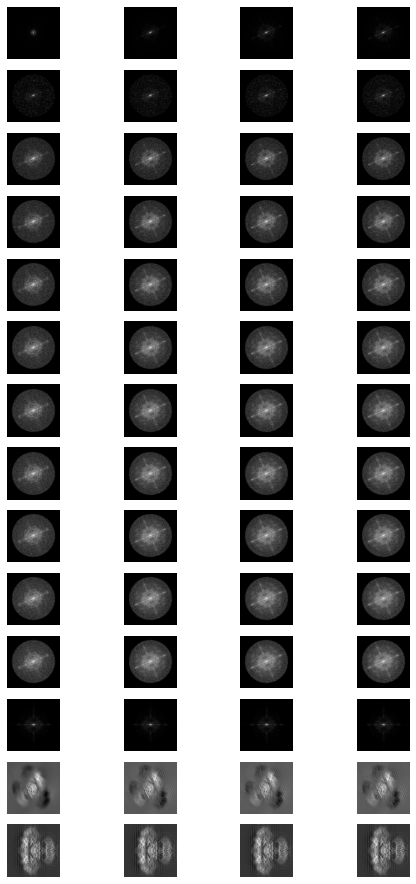

In [ ]:
n_A_updates=4
fig, axes = plt.subplots(14, n_A_updates,figsize=(8,16))
small_N = X.shape[0]

# initialize
x_aligned = np.zeros_like(A_rot)
A_rot = np.zeros((nx,nx,angles.shape[0]), dtype=np.complex64)
best_X = np.zeros_like(X[:small_N])
corr_A_x = np.zeros_like(A_rot[0,0], dtype=np.float32)
best_angles = np.zeros(small_N)
for c in range(n_A_updates):
  
  ll=0
  A_prev = A_next.copy()
  #A_next = np.zeros_like(A_prev)

  # window
  A_prev[bool_circle_mask] = 0

  axes[0,c].imshow(log_abs(A_next),cmap='gray') ; axes[0,c].set_axis_off()

  # reference alignments of template
  #A_rot = np.zeros((nx,nx,angles.shape[0]), dtype=np.complex64)
  for angle_idx in range(angles.shape[0]):
    A_rot[:,:,angle_idx] = do_complex_rotate(A_prev,angle=angles[angle_idx])


  # table of norms
  A_aligned_norm = np.linalg.norm(A_rot[:,:,:],axis=(0,1))**2
  A_aligned_norm_  = -(2*sigma**2)**-1*A_aligned_norm

  # pdf shifts

  r=0

  for i,x in enumerate(X[:small_N].copy()):
    #print('image %i'%i)

    # wf ctf
    x *= ctf_2ds[i]/(ctf_2ds[i]**2+1/snr_wf)

    # window
    x[bool_circle_mask] = 0

    # corr
    corr_A_x = np.zeros_like(A_rot[0,0], dtype=np.float32)
    for angle_idx in range(angles.shape[0]):
      corr_A_x[angle_idx] = comp_corr(x[~bool_circle_mask],A_rot[:,:,angle_idx][~bool_circle_mask])
    
    #Ki, gi
    corr_A_x_ = sigma**-2*corr_A_x
    loggi = A_aligned_norm_ + corr_A_x_ 
    Ki = loggi.max()
    gi = np.exp(loggi-Ki)

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev alignment
    x_aligned = np.zeros_like(A_rot)
    for angle_idx in range(angles.shape[0]):
          x_aligned[:,:,angle_idx] = do_complex_rotate(x,-angles[angle_idx]) 

    # point estimate of best angle
    angle_idx_best = np.argmax(gi)
    best_angles[i] = angles[angle_idx_best]
    # A_next += x_aligned[:,:,angle_idx_best]
    best_X[i] = x_aligned[:,:,angle_idx_best]

    # update A
    A_next += Ui*np.multiply(gi.reshape(1,1,-1),x_aligned).sum(axis=-1)

    if i % np.ceil(X[:small_N].shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,np.abs(A_next).max()))
      axes[r+1,c].imshow(log_abs(A_next),cmap='gray')
      axes[r+1,c].set_axis_off()
      r+=1
  A_next[bool_circle_mask] = 0

  A_next /= small_N
  axes[r+1,c].imshow(log_abs(A),cmap='gray') ; axes[r+1,c].set_axis_off()
  axes[r+2,c].imshow(do_ifft(A_next),cmap='gray') ; axes[r+2,c].set_axis_off()
  axes[r+3,c].imshow(do_ifft(A),cmap='gray') ; axes[r+3,c].set_axis_off()


We can see that the FFT has a "X" pattern, instead of a line. This suggests that the particle is being misaligned by 180 degrees.

Let's compare the true angles to the "best angles" (most likely estimated angles for each particle).

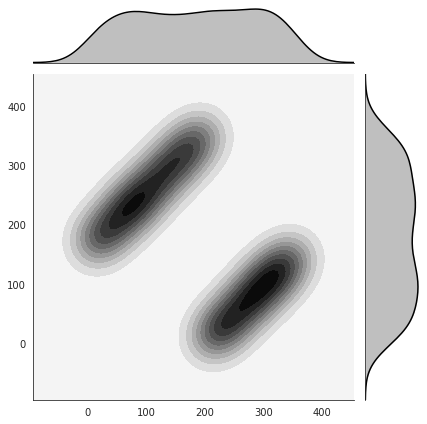

In [ ]:
import seaborn as sns
with sns.axes_style("white"):
    sns.jointplot(x=true_angles[:small_N], y=best_angles[:small_N], kind="kde", color="k");

# Conclusion

Here we see two subsets, offset by 180 deg. The angles are not exactly on the diagonal, because the reference can settle on any angle, which offsets it from the true angles.

In general, depending on the view, we will see offsets of 180 degrees (side view), or 90 degrees (top view C4 symmetry).

Probably more iterations are needed.

By looking at the alignments in Fourier space, we can get a sense of what resolution the noise goes to. We could have a more aggressive mask in Fourier space or downsample the images to a smaller size and speed up the computation.

We could also have a more complex noise model that was radially dependent, and that learned the weightings in each Fourier ring from the data.

